In [1]:
#002 What we're going to cover in Milestone Project 2 (NLP for medical abstracts)
#003 SkimLit inputs and outputs
#004 Setting up our notebook for Milestone Project 2 (getting the data)
!nvidia-smi

Sun Mar 10 19:05:17 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.76                 Driver Version: 551.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P0             19W /   80W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git


In [3]:
#005 Visualising examples from the dataset (becoming one with the data)
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"


In [4]:
import os
filenames = [data_dir+ filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [5]:
def get_lines(filename):
    with open(filename,"r") as f:
        return f.readlines()
    

In [6]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
#006 Writing a preprocessing function to structure our data for modelling
def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []
    
    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()
            
            
            for abstract_line_number , abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower()
                line_data["line_number"] = abstract_line_number
                line_data["total_lines"] = len(abstract_line_split)-1
                abstract_samples.append(line_data)
                
        else:
            abstract_lines += line
            
    return abstract_samples
                
        

In [8]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
len(train_samples),len(val_samples),len(test_samples)

CPU times: total: 375 ms
Wall time: 521 ms


(180040, 30212, 30135)

In [9]:
train_samples

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [10]:
#007 Performing visual data analysis on our preprocessed text
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(15)


,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [11]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

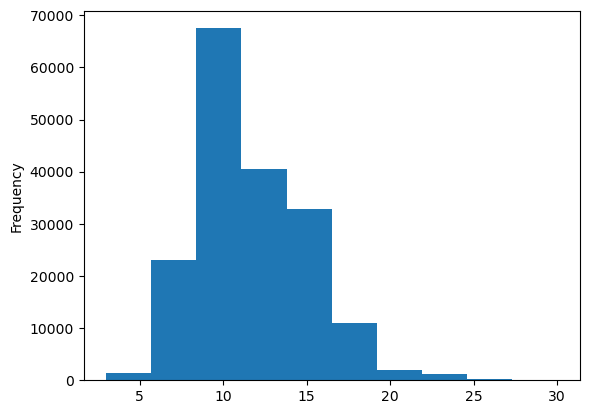

In [12]:
train_df.total_lines.plot.hist()

In [13]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [14]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [15]:
#008 Turning our target labels into numbers (ML models require numbers)
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot

C:\Users\vivek\anaconda3\envs\tensorFlowEnv\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

len(train_labels_encoded)

180040

In [17]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [18]:
#009 Model 0 Creating, fitting and evaluating a baseline model for SkimLit
#Starting a series of modelling experiments
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
model_0 = Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])

model_0.fit(X=train_sentences,y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [19]:
model_0.score(X = val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [20]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [21]:
from helper_functions import calculate_results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [22]:
#010 Preparing our data for deep sequence models
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

#How long each sentence is on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

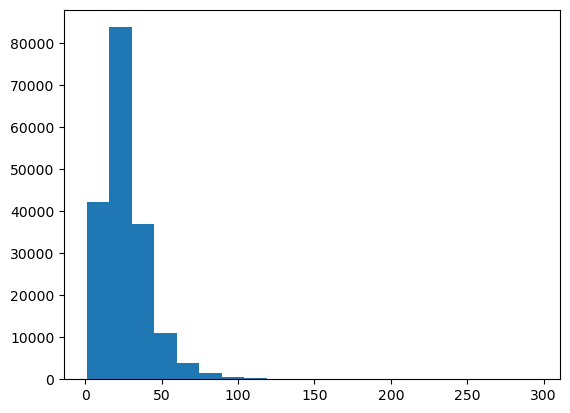

In [23]:
#Distribution
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=20)

In [24]:
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

In [25]:
#011 Creating a text vectoriser to map our tokens (text) to numbers
max_tokens = 68000
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length = output_seq_len)
text_vectorizer.adapt(train_sentences)

In [26]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
seventy-nine patients were randomised : ce : @ patients ; pva-p : @ patients .

Length of text: 15

Vectorized text: [[ 9307    12     9   210  3829    12 21999    12     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [27]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [28]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [29]:
#012 Creating a custom token embedding layer with TensorFlow
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim = 128,
                               mask_zero=True,
                               name= "token_embedding")

In [30]:
embedded_sentence=token_embed(text_vectorizer([target_sentence]))
embedded_sentence

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[-0.04439442, -0.03391571,  0.00510114, ...,  0.03406424,
         -0.03580957,  0.02749589],
        [ 0.04809299,  0.00353776,  0.03570956, ...,  0.02796863,
         -0.03569504,  0.02675999],
        [ 0.02435051, -0.01655092,  0.0223789 , ...,  0.020112  ,
          0.0006615 ,  0.03732958],
        ...,
        [ 0.04189178, -0.0104396 , -0.03722776, ...,  0.04053423,
         -0.03039678,  0.02157715],
        [ 0.04189178, -0.0104396 , -0.03722776, ...,  0.04053423,
         -0.03039678,  0.02157715],
        [ 0.04189178, -0.0104396 , -0.03722776, ...,  0.04053423,
         -0.03039678,  0.02157715]]], dtype=float32)>

In [31]:
#013 Creating fast loading dataset with the TensorFlow tf.data API
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [32]:
train_labels_one_hot.shape

(180040, 5)

In [33]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [34]:
#014 Model 1 Building, fitting and evaluating a Conv1D with token embeddings
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [35]:
#014 Model 1 Building, fitting and evaluating a Conv1D with token embeddings
inputs = layers.Input(shape = (1,),dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64,kernel_size = 5,padding="same",activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_1 = tf.keras.Model(inputs,outputs)

#categorical_crossentropy =  when one hot encoded else sparsecategoricalcrossentropy when integers

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


In [36]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 10ms/step - loss: 0.9172 - accuracy: 0.6362 - val_loss: 0.6876 - val_accuracy: 0.7377
Epoch 2/3
562/562 [==============================] - 5s 10ms/step - loss: 0.6590 - accuracy: 0.7552 - val_loss: 0.6335 - val_accuracy: 0.7699
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6182 - accuracy: 0.7729 - val_loss: 0.5983 - val_accuracy: 0.7849


In [37]:
#Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5984 - accuracy: 0.7868


[0.5984013080596924, 0.7867734432220459]

In [38]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs,model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.4286630e-01, 1.7306526e-01, 5.8375638e-02, 2.9648432e-01,
         2.9208425e-02],
        [4.6157542e-01, 2.7206686e-01, 1.3123309e-02, 2.4441107e-01,
         8.8233659e-03],
        [1.4295186e-01, 8.0960663e-03, 2.1798916e-03, 8.4672427e-01,
         4.7984071e-05],
        ...,
        [4.7861222e-06, 6.6253840e-04, 7.5549178e-04, 3.5889191e-06,
         9.9857354e-01],
        [5.2218601e-02, 4.6825665e-01, 9.6632190e-02, 6.5327488e-02,
         3.1756511e-01],
        [1.4737640e-01, 7.1971029e-01, 4.6706535e-02, 4.1480940e-02,
         4.4725802e-02]], dtype=float32),
 (30212, 5))

In [39]:
model_1_preds = tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [40]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.6773467496359,
 'precision': 0.7838591030891029,
 'recall': 0.786773467496359,
 'f1': 0.7842548174325844}

In [41]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [42]:
#015 Preparing a pretrained embedding layer from TensorFlow Hub for Model 2
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [45]:
random_train_sentence = random.choice(train_sentences)
with tf.device('/CPU:0'):
    print(f"Random sentence:\n {random_train_sentence}")
    use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
    print(f"Sentence after embedding:\n{use_embedded_sentence}\n")
    print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 serum myoglobin and creatine kinase concentrations were determined as blood markers of muscle fiber damage .
Sentence after embedding:
[[ 6.14585578e-02  3.45063880e-02 -1.86049973e-03 -2.44555697e-02
   3.61645557e-02  5.93397357e-02  4.60969098e-02 -3.84254530e-02
   9.57195368e-03  3.87386745e-03  7.59237856e-02  6.58082739e-02
   1.76750459e-02  1.24391103e-02 -7.93875102e-03 -7.43938163e-02
  -7.46919513e-02 -4.73052524e-02  7.30065480e-02 -5.84155992e-02
  -2.41491906e-02  3.66562381e-02 -6.75359927e-03  1.25940191e-02
   2.90416032e-02 -6.31359220e-03 -8.26325919e-03  5.24868630e-02
  -4.16767895e-02 -2.71782707e-02 -5.75735904e-02  7.34174326e-02
  -2.64854040e-02 -1.11534977e-02 -5.02884351e-02 -9.63464752e-03
  -5.06268330e-02 -7.47841448e-02  6.09562322e-02 -1.59557313e-02
  -5.07393815e-02  6.46845251e-02 -2.34624054e-02  1.78867728e-02
   7.53166750e-02  4.81080357e-03 -5.78871109e-02 -1.70827731e-02
   6.45625591e-02  4.45983671e-02 -3.11673116e-02 -5.10

In [46]:
#016 Model 2 Building, fitting and evaluating a Conv1D model with token embeddings
inputs = layers.Input(shape = [],dtype = tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128,activation="relu")(pretrained_embedding)
outputs = layers.Dense(5,activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,outputs=outputs,name = "model_2_USE_feature_extractor")
model_2.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [47]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [49]:
with tf.device('/CPU:0'):
    history_model_2=model_2.fit(train_dataset,epochs=3,
                                steps_per_epoch=int(0.1*len(train_dataset)),
                                validation_data=valid_dataset,
                                validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 17ms/step - loss: 0.9187 - accuracy: 0.6504 - val_loss: 0.7990 - val_accuracy: 0.6918
Epoch 2/3
562/562 [==============================] - 9s 17ms/step - loss: 0.7705 - accuracy: 0.7006 - val_loss: 0.7589 - val_accuracy: 0.7028
Epoch 3/3
562/562 [==============================] - 9s 15ms/step - loss: 0.7563 - accuracy: 0.7094 - val_loss: 0.7459 - val_accuracy: 0.7101


In [51]:
with tf.device('/CPU:0'):
    model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7461 - accuracy: 0.7116


In [53]:
with tf.device('/CPU:0'):
    model_2_pred_probs=model_2.predict(valid_dataset)
    model_2_preds = tf.argmax(model_2_pred_probs,axis=1)
    model_2_results = calculate_results(y_true=val_labels_encoded,y_pred=model_2_preds)
    model_2_results

945/945 [==============================] - 10s 11ms/step


In [54]:
model_2_results

{'accuracy': 71.16377598305309,
 'precision': 0.7120106349524967,
 'recall': 0.7116377598305309,
 'f1': 0.708673438537713}

In [55]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [56]:
#017 Creating a character-level tokeniser with TensorFlow's TextVectorization layer
def split_chars(text):
    return " ".join(list(text))

split_chars(random_train_sentence)

's e r u m   m y o g l o b i n   a n d   c r e a t i n e   k i n a s e   c o n c e n t r a t i o n s   w e r e   d e t e r m i n e d   a s   b l o o d   m a r k e r s   o f   m u s c l e   f i b e r   d a m a g e   .'

In [58]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[:5])

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .', 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .', 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a n 

In [70]:
chars_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(chars_lens)
mean_char_len

149.3662574983337

In [71]:
chars_lens

[281,
 137,
 111,
 65,
 209,
 147,
 161,
 164,
 180,
 51,
 188,
 248,
 79,
 167,
 175,
 245,
 120,
 140,
 163,
 186,
 162,
 191,
 251,
 114,
 70,
 131,
 377,
 93,
 94,
 130,
 125,
 209,
 34,
 90,
 118,
 26,
 124,
 43,
 246,
 285,
 65,
 120,
 131,
 131,
 203,
 245,
 195,
 106,
 110,
 144,
 138,
 87,
 59,
 113,
 102,
 146,
 116,
 108,
 217,
 155,
 107,
 112,
 115,
 59,
 201,
 37,
 204,
 129,
 146,
 154,
 89,
 105,
 90,
 66,
 109,
 65,
 93,
 114,
 103,
 212,
 136,
 86,
 225,
 194,
 89,
 263,
 158,
 407,
 100,
 228,
 193,
 106,
 203,
 134,
 148,
 257,
 268,
 296,
 46,
 90,
 113,
 230,
 262,
 193,
 200,
 37,
 240,
 273,
 98,
 176,
 282,
 101,
 177,
 235,
 337,
 100,
 159,
 222,
 201,
 214,
 79,
 132,
 176,
 133,
 93,
 133,
 122,
 241,
 74,
 96,
 164,
 157,
 61,
 166,
 31,
 94,
 134,
 188,
 63,
 128,
 123,
 81,
 38,
 77,
 68,
 120,
 91,
 109,
 108,
 150,
 108,
 265,
 207,
 140,
 270,
 123,
 63,
 161,
 196,
 86,
 272,
 116,
 218,
 48,
 156,
 64,
 492,
 159,
 169,
 206,
 237,
 111,
 126,
 102,

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

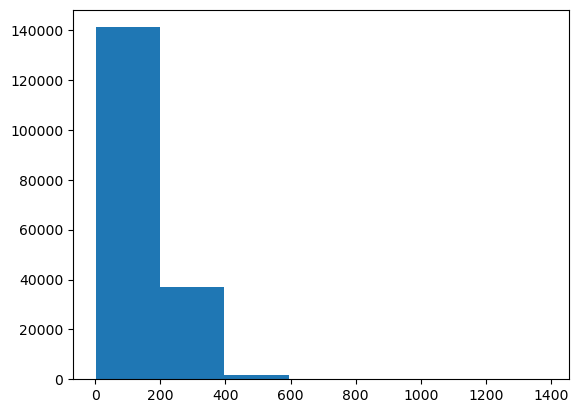

In [60]:
import matplotlib.pyplot as plt
plt.hist(chars_lens,bins=7)

In [61]:
output_seq_char_len = int(np.percentile(chars_lens,95))
output_seq_char_len

290

In [62]:
import string
alphabet = string.ascii_lowercase+string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [64]:
NUM_CHAR_TOKENS = len(alphabet)+2 #ass 2 for space and OOV ([UNK])
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,output_sequence_length=output_seq_char_len,name="char_vectorizer") # set stanadardize = None if you want to leave punctuation in

In [65]:
char_vectorizer.adapt(train_chars)

In [81]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [84]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars:\n {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 a n   i n t e n t i o n - t o - t r e a t   a n a l y s i s   o f   a d j u s t e d   e f f e c t   s i z e   (   e s   )   w a s   a p p l i e d   .

Length of random_train_chars:
 63

Vectorized chars:
 [[ 5  6  4  6  3  2  6  3  4  7  6  3  7  3  8  2  5  3  5  6  5 12 19  9
   4  9  7 17  5 10 27 16  9  3  2 10  2 17 17  2 11  3  9  4 25  2  2  9
  20  5  9  5 14 14 12  4  2 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0 

In [ ]:
#018 Creating a character-level embedding layer with tf.keras.layers.Embedding